In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
data=pd.read_csv('df_jepx_spotsum.csv')

# Ensure DATETIME is in datetime format and sort the data
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.sort_values('DATETIME', inplace=True)

# We focus only on the SYSTEM_PRICE for the LSTM model
prices = data['SYSTEM_PRICE'].values.reshape(-1, 1)

In [4]:
# Function to create sequences of data points for the LSTM model
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define the sequence length (number of time steps)
sequence_length = 1  # Corresponding to 48 hours of data at 30 minute intervals

In [9]:
# Create sequences
X, y = create_sequences(prices, sequence_length)

In [12]:
len(X)

325794

In [13]:
len(y)

325794

In [16]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((260635, 30, 1), (65159, 30, 1), (260635, 1), (65159, 1))

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
# Due to resource limitations, we will limit the number of epochs and batch size
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test))

# Summarize the model's architecture
model.summary()

Epoch 1/5
3564/3564 [==============================] - 74s 20ms/step - loss: 10.2668 - val_loss: 3.5227
Epoch 2/5
3564/3564 [==============================] - 84s 24ms/step - loss: 4.5490 - val_loss: 2.9842
Epoch 3/5
3564/3564 [==============================] - 82s 23ms/step - loss: 4.3827 - val_loss: 3.4544
Epoch 4/5
3564/3564 [==============================] - 81s 23ms/step - loss: 4.5514 - val_loss: 3.0717
Epoch 5/5
3564/3564 [==============================] - 79s 22ms/step - loss: 4.0355 - val_loss: 5.3405
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
  

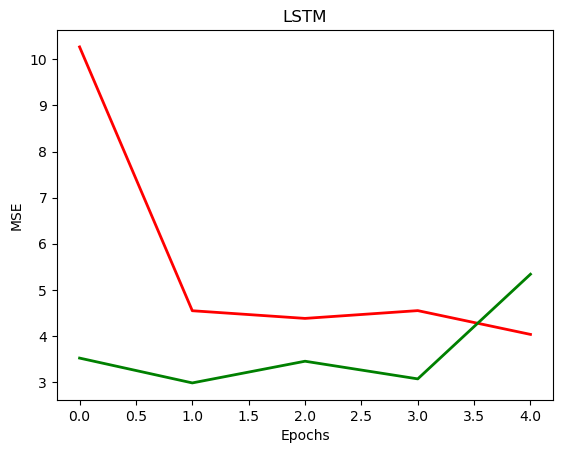

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [25]:
predicted_prices = model(X_test)

In [28]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(predicted_prices, y_test)
MAE

5.3404981958617315

In [29]:
from sklearn.metrics import r2_score
R2=r2_score(predicted_prices, y_test)
R2

0.9314457251855678

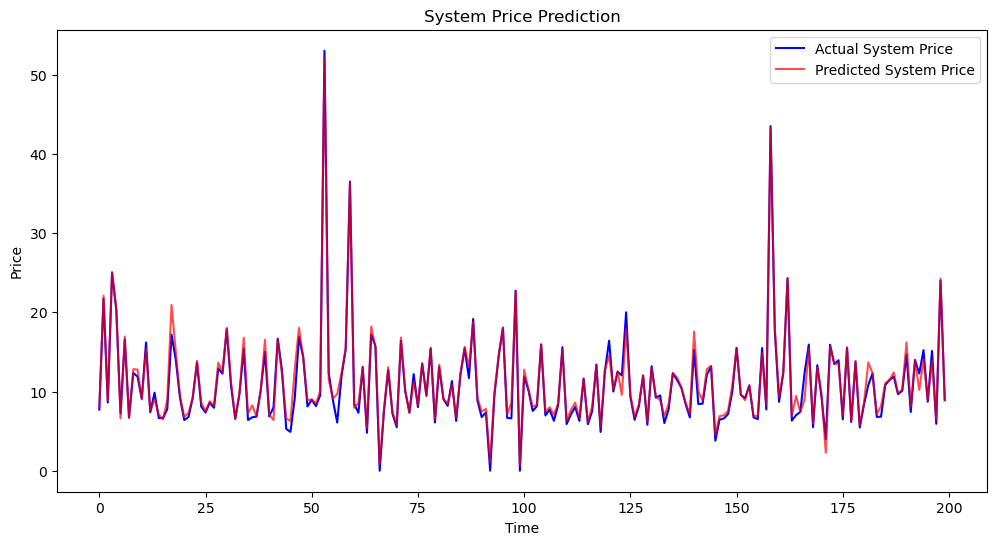

In [32]:
import matplotlib.pyplot as plt

# Plotting the actual and predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test[:200], color='blue', label='Actual System Price')
plt.plot(predicted_prices[:200], color='red', alpha=0.7, label='Predicted System Price')
plt.title('System Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()